# Import the required libraries

In [1]:
import findspark
findspark.init('/home/ecomog/spark-2.4.3-bin-hadoop2.7')
import pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import (isnan, count, when, col, desc, udf,
        col, sort_array, asc, avg)
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load data

In [3]:
# create a spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

# Explore Data

In [5]:
user_log.count(), len(user_log.columns)

(10000, 18)

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046')

In [9]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [10]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [11]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



Answering questions using spark dataframe

In [12]:
# Finding the number of unique pages users visited
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [13]:
# Selecting some columns for userID 1046
user_log.select(["userId", "firstname", "page", "song", 'ts']).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall', ts=1513720872284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman', ts=1513721104284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1', ts=1513721310284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants', ts=1513721591284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son', ts=1513721808284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5', ts=1513721976284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen', ts=1513722161284),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None, ts=1513837636284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war', ts=1513837660284),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street', ts=1513837887284),
 Row(us

In [23]:
# Finding the most visited page and its number
user_log.groupby('page').count().sort(desc('count')).collect()

[Row(page='NextSong', count=8347),
 Row(page='Home', count=1126),
 Row(page='Login', count=126),
 Row(page='Logout', count=100),
 Row(page='Downgrade', count=75),
 Row(page='Settings', count=59),
 Row(page='Help', count=58),
 Row(page='About', count=43),
 Row(page='Upgrade', count=32),
 Row(page='Error', count=12),
 Row(page='Save Settings', count=11),
 Row(page='Submit Upgrade', count=10),
 Row(page='Submit Downgrade', count=1)]

In [34]:
# Finding the  most played artist and its number
user_log.filter(user_log['page'] == 'NextSong').select('Artist').groupBy('Artist')\
    .agg({'Artist': 'count'}).withColumnRenamed('count(Artist)', 'Artistcount')\
    .sort(desc('Artistcount')).collect()

[Row(Artist='Coldplay', Artistcount=83),
 Row(Artist='Kings Of Leon', Artistcount=69),
 Row(Artist='Florence + The Machine', Artistcount=52),
 Row(Artist='BjÃ\x83Â¶rk', Artistcount=46),
 Row(Artist='Dwight Yoakam', Artistcount=45),
 Row(Artist='Justin Bieber', Artistcount=43),
 Row(Artist='The Black Keys', Artistcount=40),
 Row(Artist='OneRepublic', Artistcount=37),
 Row(Artist='Jack Johnson', Artistcount=36),
 Row(Artist='Muse', Artistcount=36),
 Row(Artist='Radiohead', Artistcount=31),
 Row(Artist='Taylor Swift', Artistcount=29),
 Row(Artist='Lily Allen', Artistcount=28),
 Row(Artist='Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner', Artistcount=28),
 Row(Artist='Train', Artistcount=28),
 Row(Artist='Nickelback', Artistcount=27),
 Row(Artist='Metallica', Artistcount=27),
 Row(Artist='Daft Punk', Artistcount=27),
 Row(Artist='Kanye West', Artistcount=26),
 Row(Artist='John Mayer', Artistcount=24),
 Row(Artist='Red Hot Chili Peppers', Artistcount=24),
 Row(Artist

In [5]:
# How many songs do users listen to on average between visiting our home page 
# to the closest integer.

# filter out 0 sum and max sum to get more exact answer
is_home = udf(lambda x : int(x == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cumsum = user_log.filter((user_log.page == 'NextSong') | (user_log.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', is_home(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cumsum.filter((cumsum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+



Answering some questions using spark sql

In [55]:
# What pages does users with empty("") userID did not visit
# Creating a tempview first
user_log.createOrReplaceTempView('user_log_table')

spark.sql("SELECT * FROM\
             (SELECT DISTINCT page FROM user_log_table) AS all_pages\
          LEFT JOIN\
              (SELECT DISTINCT page FROM user_log_table WHERE userID == '')\
               AS blankUserID_pages\
          ON all_pages.page = blankUserID_pages.page\
          WHERE blankUserID_pages.page IS NULL").show()
           

+----------------+----+
|            page|page|
+----------------+----+
|Submit Downgrade|null|
|       Downgrade|null|
|          Logout|null|
|   Save Settings|null|
|        Settings|null|
|        NextSong|null|
|         Upgrade|null|
|           Error|null|
|  Submit Upgrade|null|
+----------------+----+



Calculating Statistics by Hour

In [16]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log.head()

songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

# Converting songs_in_hour to pandas and visualizing
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

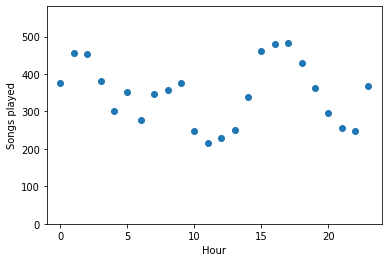

In [17]:
# Visualising 
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [5]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
print(user_log_valid.count())
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
print(user_log_valid.count())

10000
9664


Finding users that Churn 

In [6]:
# Create a flat-downgraed function and apply to get the users that downgraded their account
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("churned", flag_downgrade_event("page"))
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', churned=0)

In [9]:
# Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn("phase", Fsum("churned").over(windowval))
print(user_log_valid.head())
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

Row(artist='Fabolous / The-Dream', auth='Logged In', firstName='Kevin', gender='M', itemInSession=1, lastName='Gilbert', length=231.54893, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1505550349284, sessionId=1435, song='Throw It In The Bag', status=200, ts=1513783259284, userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='1436', churned=0, phase=0)


[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs